## **Problem 2) DCGAN on PathMnist dataset**




In [2]:
import torch

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
!pip install medmnist tqdm  

In [4]:
#imports
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import medmnist
from medmnist import PathMNIST
from scipy import linalg


In [5]:
# random seed
def set_random_seed(seed_value=42):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    return seed_value

seed = set_random_seed(42)


In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    cuda_device_name = torch.cuda.get_device_name(0)
    cuda_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"CUDA Device: {cuda_device_name}")
    print(f"CUDA Memory: {cuda_memory:.2f} GB")


Using device: cuda
CUDA Device: Tesla P100-PCIE-16GB
CUDA Memory: 17.06 GB


In [7]:
# Hyperparameters
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
z_dim = 100
image_size = 28  # PathMNIST is 28x28
channels = 3  # PathMNIST has 3 color channels
epochs = 1000  # 1000 epochs

print("Hyperparameters:")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {lr}")
print(f"Beta1: {beta1}, Beta2: {beta2}")
print(f"Latent dimension: {z_dim}")
print(f"Image size: {image_size}")
print(f"Channels: {channels}")
print(f"Epochs: {epochs}")


Hyperparameters:
Batch size: 64
Learning rate: 0.0002
Beta1: 0.5, Beta2: 0.999
Latent dimension: 100
Image size: 28
Channels: 3
Epochs: 1000


In [8]:
def load_dataset():
    print("Loading MedMNIST dataset...")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    try:
        # loading the PathMNIST dataset
        print("Loading training dataset...")
        train_dataset = PathMNIST(split="train", transform=transform, download=True)
        print("Training dataset loaded successfully.")
        
        print("Loading test dataset...")
        test_dataset = PathMNIST(split="test", transform=transform, download=True)
        print("Test dataset loaded successfully.")
        
        print(f"Dataset size: {len(train_dataset)}")
        print(f"Image shape: {train_dataset[0][0].shape}")
        
        sample_img = train_dataset[0][0]
        print(f"Sample image range: Min={sample_img.min():.4f}, Max={sample_img.max():.4f}")        
        print("Creating data loaders...")
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
        )
        print("Data loaders created successfully.")
        
        return train_dataset, test_dataset, train_loader, test_loader
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        print(traceback.format_exc())
        raise

train_dataset, test_dataset, train_loader, test_loader = load_dataset()


Loading MedMNIST dataset...
Loading training dataset...
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training dataset loaded successfully.
Loading test dataset...
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Test dataset loaded successfully.
Dataset size: 89996
Image shape: torch.Size([3, 28, 28])
Sample image range: Min=0.2863, Max=0.7882
Creating data loaders...
Data loaders created successfully.


In [9]:
# checking the image dimension
sample_img, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_img.shape}")


Sample image shape: torch.Size([3, 28, 28])


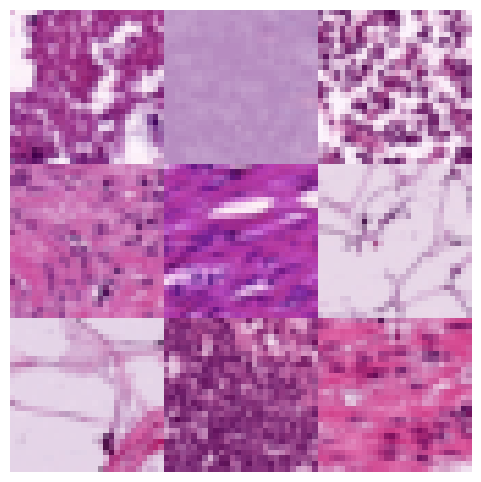

In [10]:
# displaying the first 9 images from the dataset
def show_first_9_images(train_loader):
    images, labels = next(iter(train_loader))    
    grid = make_grid(images[:9], nrow=3, padding=0, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

show_first_9_images(train_loader)


cuda


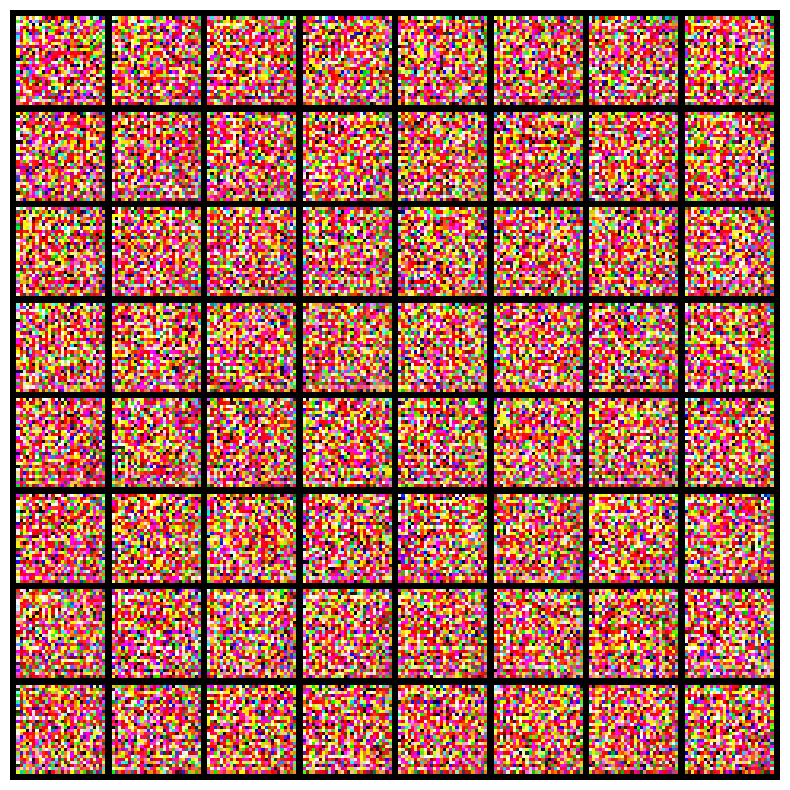

Generated image batch shape: torch.Size([64, 3, 28, 28])


In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid

# print grid of images
def display_images(image_batch, nrow=8):
    """Displays a grid of images"""
    grid_img = make_grid(image_batch, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

class Generator(nn.Module):
    def __init__(self, z_dim, channels=3):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.project = nn.Linear(z_dim, 1024 * 4 * 4)
        
        # Transposed convolution blocks
        self.conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # final convolution layer match the real input images
        self.conv4 = nn.ConvTranspose2d(128, channels, kernel_size=5, stride=1, padding=4, output_padding=0)
    
    def forward(self, z):
        x = self.project(z)
        
        x = x.view(-1, 1024, 4, 4)
        
        # Transposed convolution blocks with ReLU activation
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Final layer with tanh activation to get values in [-1, 1]
        x = self.conv4(x)
        x = torch.tanh(x)
        
        return x

# generator model
z_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(z_dim).to(device)
print(device)  # Should say: cuda


batch_size = 64
latent_vectors = torch.randn(batch_size, z_dim).to(device)

generated_images = generator(latent_vectors)

# Display the generated images
display_images(generated_images)
print("Generated image batch shape:", generated_images.shape)


Initialized dense layer with input size: 1024
Discriminator output shape: torch.Size([64, 1])


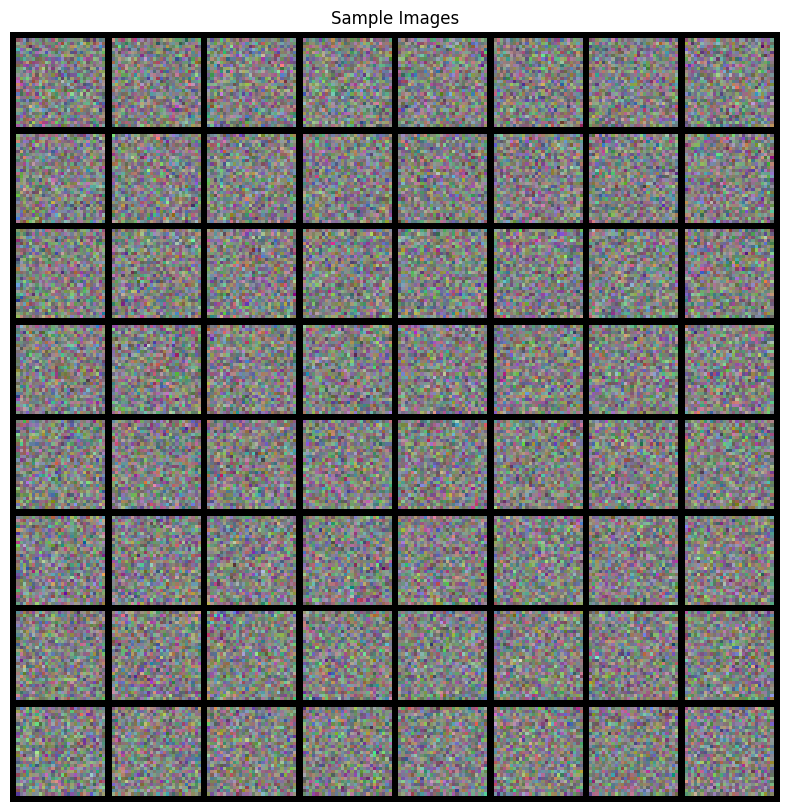

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        # 1st convo layer
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=2, padding=2)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)
        
        # 2nd convo layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        
        # 3rd convo layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        # 4th convo layer
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        
        # 5th convo layer
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(1024)
        self.lrelu5 = nn.LeakyReLU(0.2, inplace=True)
        
        # Output layer
        self.flatten = nn.Flatten()
        self.dense = None
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.lrelu5(x)
        
        x = self.flatten(x)
        
        if self.dense is None:
            self.dense = nn.Linear(x.shape[1], 1).to(x.device)
            print(f"Initialized dense layer with input size: {x.shape[1]}")
        
        x = self.dense(x)
        
        return x

def test_discriminator():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    discriminator = Discriminator(channels=3).to(device)    
    batch_size = 64
    test_images = torch.randn(batch_size, 3, 28, 28).to(device)    
    output = discriminator(test_images)
    print("Discriminator output shape:", output.shape)
    
    display_images(test_images)
    
    return discriminator

#  64 grid of images
def display_images(image_batch, nrow=8):
    """Displays a grid of images"""
    grid_img = make_grid(image_batch[:64], nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Sample Images")
    plt.show()

if __name__ == "__main__":
    test_discriminator()

    


In [13]:
# used Binary Cross Entropy with logits (raw output)
criterion = nn.BCEWithLogitsLoss()

# Generator loss
def generator_loss(discriminator, fake_images):
    # fooling the discriminator — label as real (1)
    labels = torch.ones(fake_images.size(0), 1).to(fake_images.device)
    outputs = discriminator(fake_images)
    loss = criterion(outputs, labels)
    return loss

# Discriminator loss
def discriminator_loss(discriminator, real_images, fake_images):
    real_labels = torch.ones(real_images.size(0), 1).to(real_images.device)
    real_outputs = discriminator(real_images)
    real_loss = criterion(real_outputs, real_labels)

    fake_labels = torch.zeros(fake_images.size(0), 1).to(fake_images.device)
    fake_outputs = discriminator(fake_images.detach())
    fake_loss = criterion(fake_outputs, fake_labels)

    return real_loss + fake_loss


In [14]:
generator = Generator(z_dim).to(device)
discriminator = Discriminator(channels=3).to(device)
print(device)  # Should say: cuda


# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


cuda


In [15]:
def train_discriminator(generator, discriminator, real_images, z, optimizer):
    real_images = real_images.to(device)
    z = z.to(device)
    fake_images = generator(z)

    # Compute loss
    loss = discriminator_loss(discriminator, real_images, fake_images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [16]:
# training generator step
def train_generator(generator, discriminator, z_batch, optimizer):
    generator.train()
    discriminator.eval()

    optimizer.zero_grad()

    fake_images = generator(z_batch)

    # Compute generator loss
    g_loss = generator_loss(discriminator, fake_images)
    g_loss.backward()
    optimizer.step()

    return g_loss.item()


In [17]:
!pip install torchsummary

from torchsummary import summary

generator = Generator(z_dim).to(device)
discriminator = Discriminator(channels=3).to(device)
print(device)  # Should say: cuda

# Print model summaries
print("Generator Summary:")
summary(generator, input_size=(z_dim,))

print("\nDiscriminator Summary:")
summary(discriminator, input_size=(3, 28, 28))


cuda
Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16384]       1,654,784
   ConvTranspose2d-2            [-1, 512, 8, 8]      13,107,712
       BatchNorm2d-3            [-1, 512, 8, 8]           1,024
   ConvTranspose2d-4          [-1, 256, 16, 16]       3,277,056
       BatchNorm2d-5          [-1, 256, 16, 16]             512
   ConvTranspose2d-6          [-1, 128, 32, 32]         819,328
       BatchNorm2d-7          [-1, 128, 32, 32]             256
   ConvTranspose2d-8            [-1, 3, 28, 28]           9,603
Total params: 18,870,275
Trainable params: 18,870,275
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.64
Params size (MB): 71.98
Estimated Total Size (MB): 75.63
----------------------------------------------------------------

Discrimin

In [18]:
from tqdm import tqdm

# used learning rate and early stopping with patience=20
lr = 0.0002
patience = 40
best_gen_loss = float('inf')
patience_counter = 0

print(device)  # Should say: cuda

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Track losses
gen_loss_profile = []
disc_loss_profile = []

fixed_noise = torch.randn(64, z_dim).to(device)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    g_running_loss = 0.0
    d_running_loss = 0.0

    loop = tqdm(train_loader, leave=False, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for real_images, _ in loop:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        z = torch.randn(batch_size, z_dim).to(device)

        # Train discriminator
        d_loss = train_discriminator(generator, discriminator, real_images, z, discriminator_optimizer)

        # Train generator
        z = torch.randn(batch_size, z_dim).to(device)
        g_loss = train_generator(generator, discriminator, z, generator_optimizer)

        d_running_loss += d_loss
        g_running_loss += g_loss

        loop.set_postfix({
            "Gen Loss": f"{g_loss:.4f}",
            "Disc Loss": f"{d_loss:.4f}"
        })

    avg_d_loss = d_running_loss / len(train_loader)
    avg_g_loss = g_running_loss / len(train_loader)

    disc_loss_profile.append(avg_d_loss)
    gen_loss_profile.append(avg_g_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Gen Loss: {avg_g_loss:.4f}, Disc Loss: {avg_d_loss:.4f}")

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).detach().cpu()
        display_images(fake_samples)

    if avg_g_loss < best_gen_loss:
        best_gen_loss = avg_g_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


cuda


Epoch [1/1000] - Gen Loss: 2.3975, Disc Loss: 0.8876


Epoch [2/1000] - Gen Loss: 2.2729, Disc Loss: 0.8867


Epoch [4/1000] - Gen Loss: 1.8988, Disc Loss: 1.0225


Epoch [7/1000] - Gen Loss: 1.8633, Disc Loss: 0.9641


Epoch [8/1000] - Gen Loss: 1.7669, Disc Loss: 1.0114


Epoch [10/1000] - Gen Loss: 1.6304, Disc Loss: 1.0388


Epoch [11/1000] - Gen Loss: 1.5727, Disc Loss: 1.0596


Epoch [12/1000] - Gen Loss: 1.4081, Disc Loss: 1.0996


Epoch [13/1000] - Gen Loss: 1.4050, Disc Loss: 1.0967


Epoch [14/1000] - Gen Loss: 1.3812, Disc Loss: 1.1053


Epoch [15/1000] - Gen Loss: 1.4371, Disc Loss: 1.1014


Epoch [16/1000] - Gen Loss: 1.2658, Disc Loss: 1.1539


Epoch [17/1000] - Gen Loss: 1.2767, Disc Loss: 1.1347


Epoch [18/1000] - Gen Loss: 1.3427, Disc Loss: 1.0975


Epoch [19/1000] - Gen Loss: 1.3710, Disc Loss: 1.0802


Epoch [20/1000] - Gen Loss: 1.4395, Disc Loss: 1.0642


Epoch [21/1000] - Gen Loss: 1.4673, Disc Loss: 1.0440


Epoch [22/1000] - Gen Loss: 1.4748, Disc Loss: 1.0324


Epoch [23/1000] - Gen Loss: 1.4509, Disc Loss: 1.0356


Epoch [24/1000] - Gen Loss: 1.4133, Disc Loss: 1.0295


Epoch [25/1000] - Gen Loss: 1.4068, Disc Loss: 1.0293


Epoch [26/1000] - Gen Loss: 1.3919, Disc Loss: 1.0256


Epoch [27/1000] - Gen Loss: 1.3992, Disc Loss: 1.0145


Epoch [28/1000] - Gen Loss: 1.4263, Disc Loss: 1.0004


Epoch [29/1000] - Gen Loss: 1.4239, Disc Loss: 0.9914


Epoch [30/1000] - Gen Loss: 1.4642, Disc Loss: 0.9790


Epoch [31/1000] - Gen Loss: 1.4864, Disc Loss: 0.9685


Epoch [32/1000] - Gen Loss: 1.5396, Disc Loss: 0.9474


Epoch [33/1000] - Gen Loss: 1.5633, Disc Loss: 0.9331


Epoch [34/1000] - Gen Loss: 1.6077, Disc Loss: 0.9127


Epoch [35/1000] - Gen Loss: 1.6837, Disc Loss: 0.8845


Epoch [36/1000] - Gen Loss: 1.7522, Disc Loss: 0.8525


Epoch [37/1000] - Gen Loss: 1.8152, Disc Loss: 0.8292


Epoch [38/1000] - Gen Loss: 1.8815, Disc Loss: 0.8110


Epoch [39/1000] - Gen Loss: 1.9646, Disc Loss: 0.7787


Epoch [40/1000] - Gen Loss: 2.0171, Disc Loss: 0.7610


Epoch [41/1000] - Gen Loss: 2.0907, Disc Loss: 0.7397


Epoch [42/1000] - Gen Loss: 2.1591, Disc Loss: 0.7190


Epoch [43/1000] - Gen Loss: 2.2495, Disc Loss: 0.6852


Epoch [44/1000] - Gen Loss: 2.3197, Disc Loss: 0.6665


Epoch [45/1000] - Gen Loss: 2.3826, Disc Loss: 0.6576


Epoch [46/1000] - Gen Loss: 2.4520, Disc Loss: 0.6329


Epoch [47/1000] - Gen Loss: 2.4980, Disc Loss: 0.6141


Epoch [48/1000] - Gen Loss: 2.5418, Disc Loss: 0.6035


Epoch [49/1000] - Gen Loss: 2.6116, Disc Loss: 0.5838


Epoch [50/1000] - Gen Loss: 2.6645, Disc Loss: 0.5727


Epoch [51/1000] - Gen Loss: 2.6971, Disc Loss: 0.5687


Epoch [52/1000] - Gen Loss: 2.7181, Disc Loss: 0.5605


Epoch [53/1000] - Gen Loss: 2.7292, Disc Loss: 0.5523


Epoch [54/1000] - Gen Loss: 2.7404, Disc Loss: 0.5481


Epoch [55/1000] - Gen Loss: 2.7565, Disc Loss: 0.5409


Epoch [56/1000] - Gen Loss: 2.7532, Disc Loss: 0.5329
Early stopping triggered at epoch 56


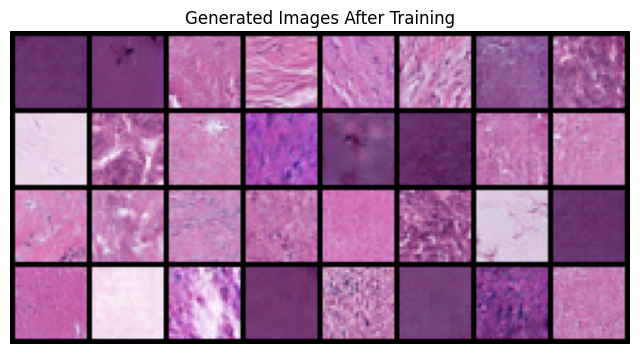

In [19]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def display_images(images, nrow=8):
    grid_img = make_grid(images[:32], nrow=nrow, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Generated Images After Training")
    plt.show()

# Display the 32 generated images using fixed noise
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

display_images(fake_images)


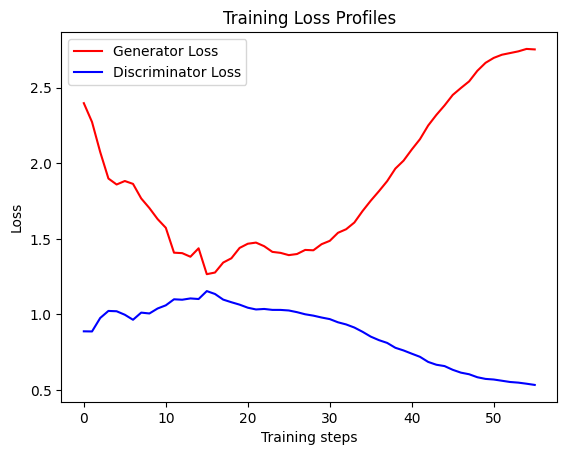

In [20]:
 
# Plot for Generator and Discriminator Losses(after training)
plt.plot(gen_loss_profile, color='red', label='Generator Loss')
plt.plot(disc_loss_profile, color='blue', label='Discriminator Loss')
plt.legend()
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.title('Training Loss Profiles')
plt.show()


In [21]:

!pip install pytorch-fid
import os
from torchvision.utils import save_image
import subprocess

# Create folders for real and fake images
os.makedirs("fid_images/real", exist_ok=True)
os.makedirs("fid_images/fake", exist_ok=True)

# Save 1000 real images
real_count = 0
for real_batch, _ in test_loader:
    for img in real_batch:
        if real_count >= 1000:
            break
        save_image(img, f"fid_images/real/{real_count}.png", normalize=True)
        real_count += 1
    if real_count >= 1000:
        break

# Save 1000 fake images
generator.eval()
with torch.no_grad():
    fake_count = 0
    while fake_count < 1000:
        z = torch.randn(batch_size, z_dim).to(device)
        fake_batch = generator(z).detach().cpu()
        for img in fake_batch:
            if fake_count >= 1000:
                break
            save_image(img, f"fid_images/fake/{fake_count}.png", normalize=True)
            fake_count += 1


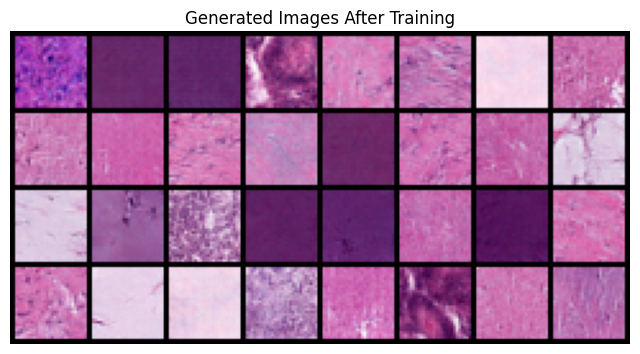

In [22]:

import torch

# 32 samples using random noise
generator.eval()
with torch.no_grad():
    test_samples_final = torch.randn(32, z_dim).to(device)
    generated_images_final = generator(test_samples_final).detach().cpu()


# Display the 32 generated images using random noise
display_images(generated_images_final)


In [23]:

# Compute FID score
fid_score = subprocess.check_output("pytorch-fid fid_images/real fid_images/fake", shell=True).decode("utf-8")
print("FID Score:", fid_score)


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 79.7MB/s]
100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


FID Score: FID:  102.12400348153452



### Explanation:

* The above Deep Convolutional GAN (DCGAN) on the PathMNIST dataset has a generator architecture based on the given ConvTranspose2D block diagram.
* The discriminator used 5 convolutional layers with LeakyReLU activations and BatchNorm. The model was trained for up to 1000 epochs with early stopping (patience=40), which trigerred at epoch 56.
* Generator and discriminator losses showed stable trends with no evidence of mode collapse.
* The computed FID score used 1000 real and 1000 generated images, obtaining a score of 102.12.
* Visual inspection of generated images showed variety in texture and color, confirming the absence of mode collapse.




### Hyperparameter used:
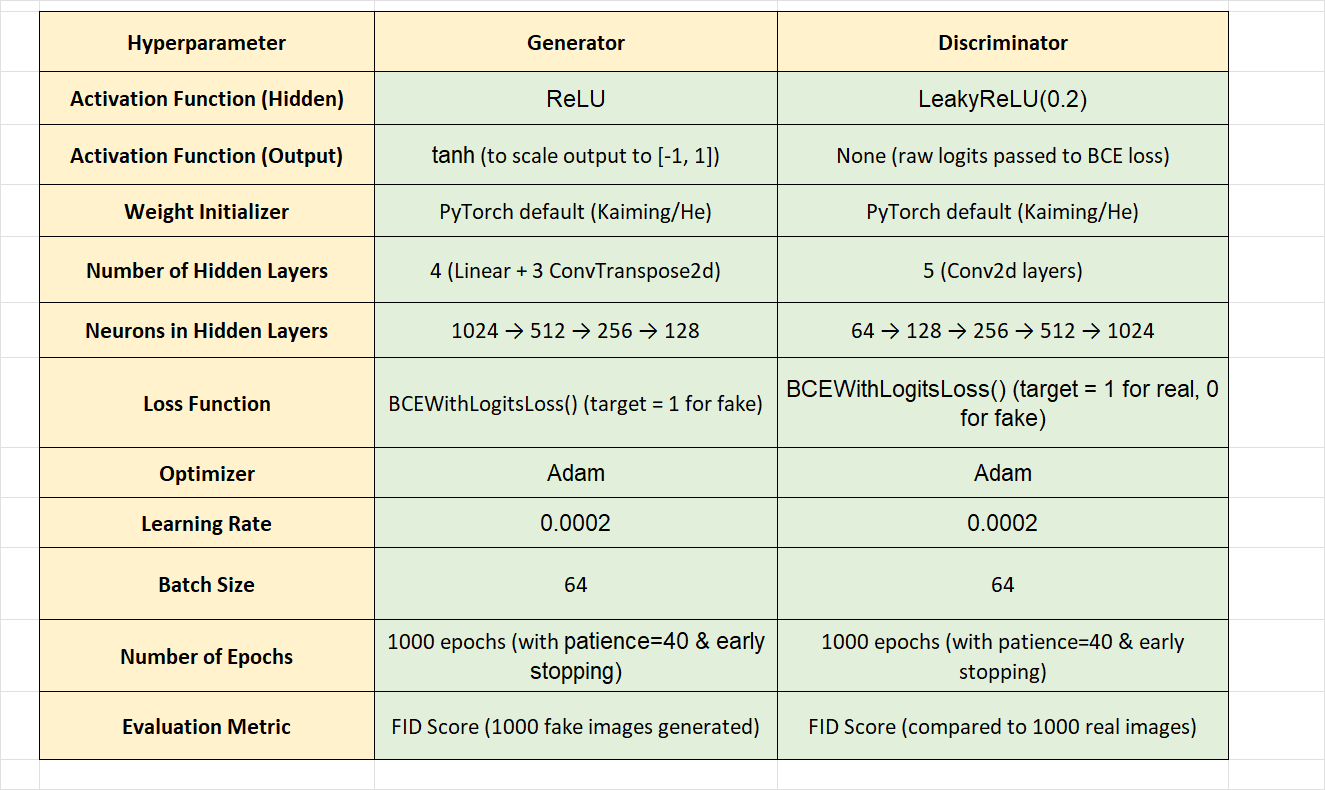
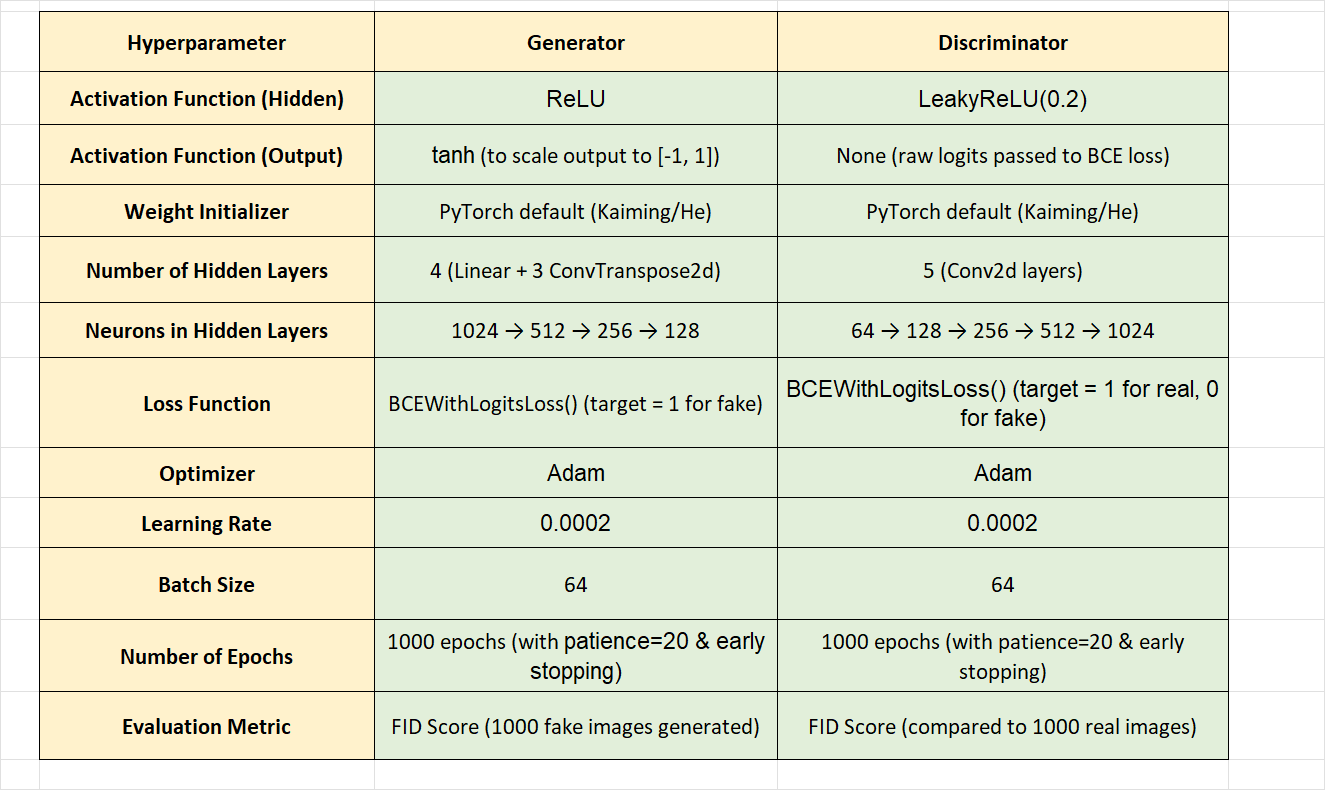
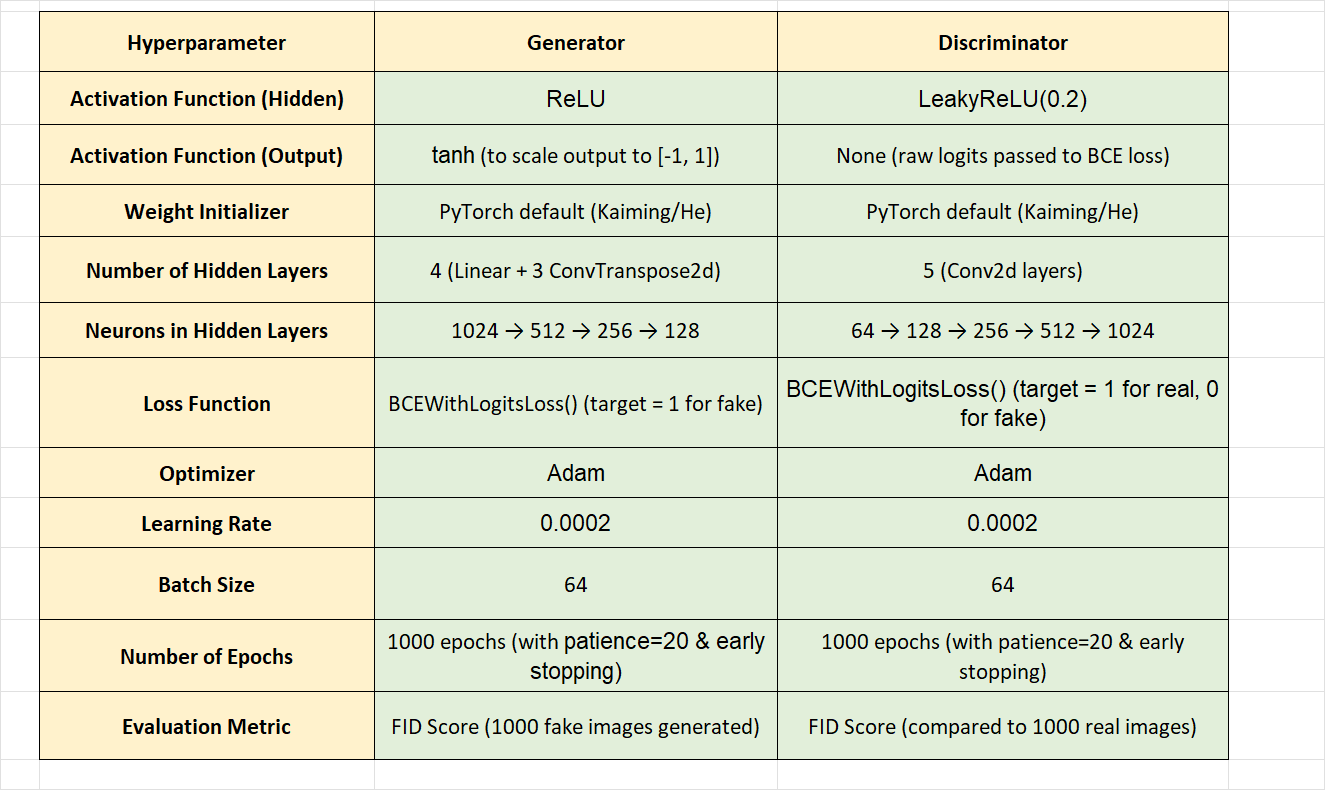
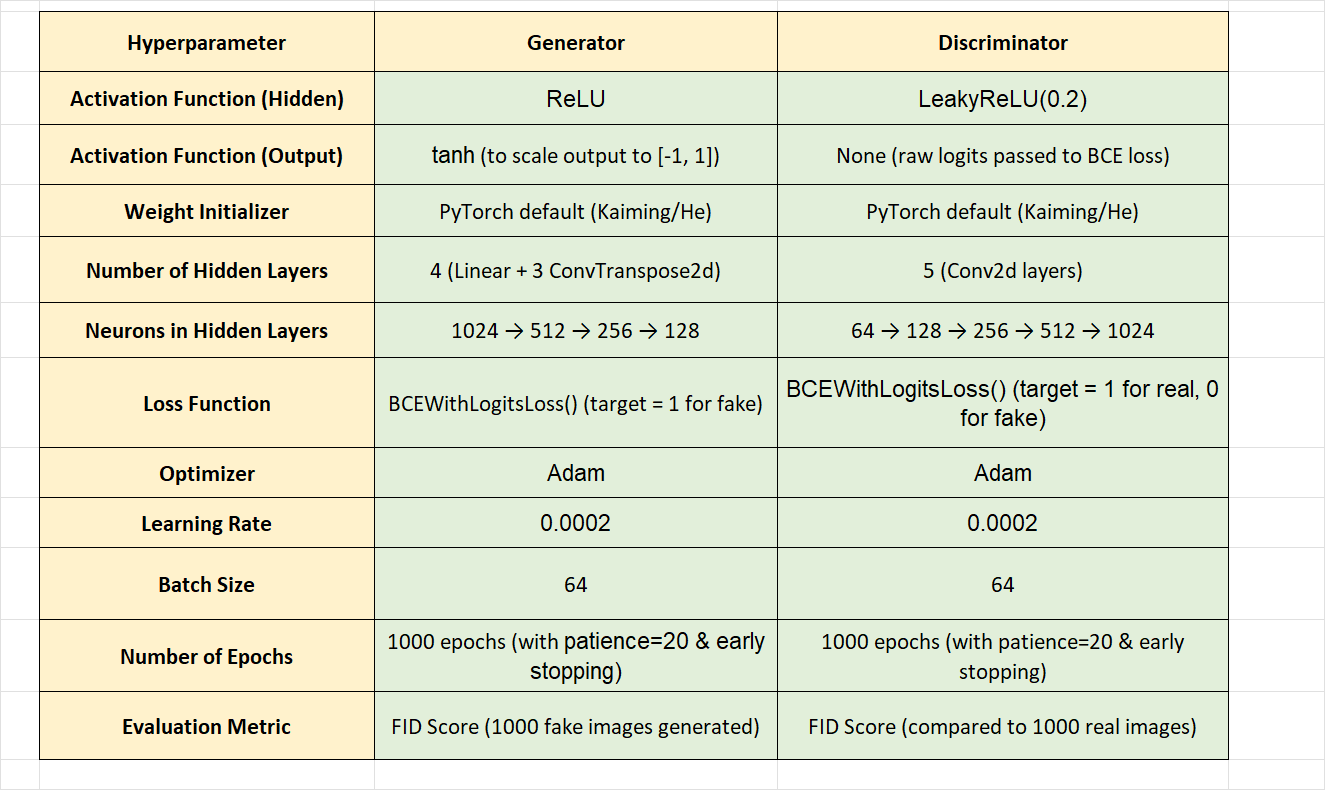
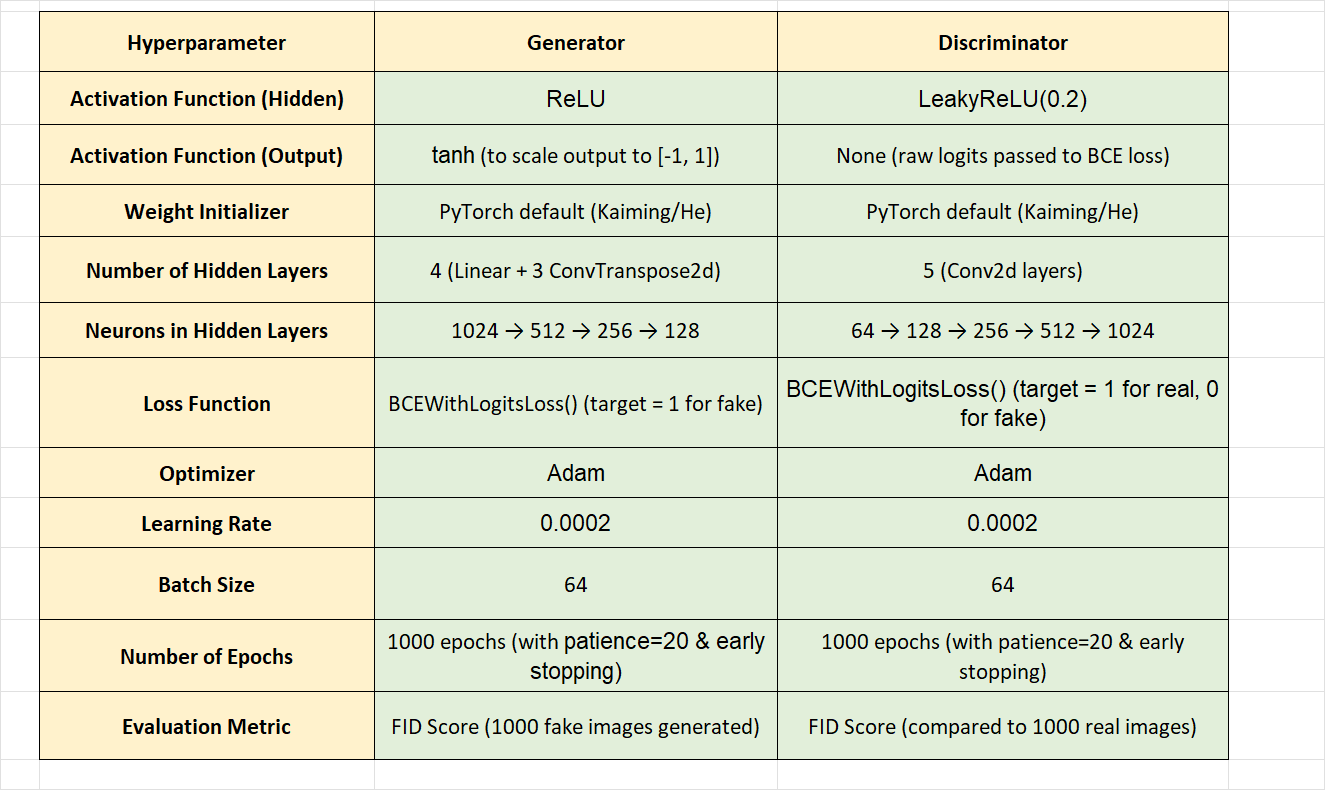
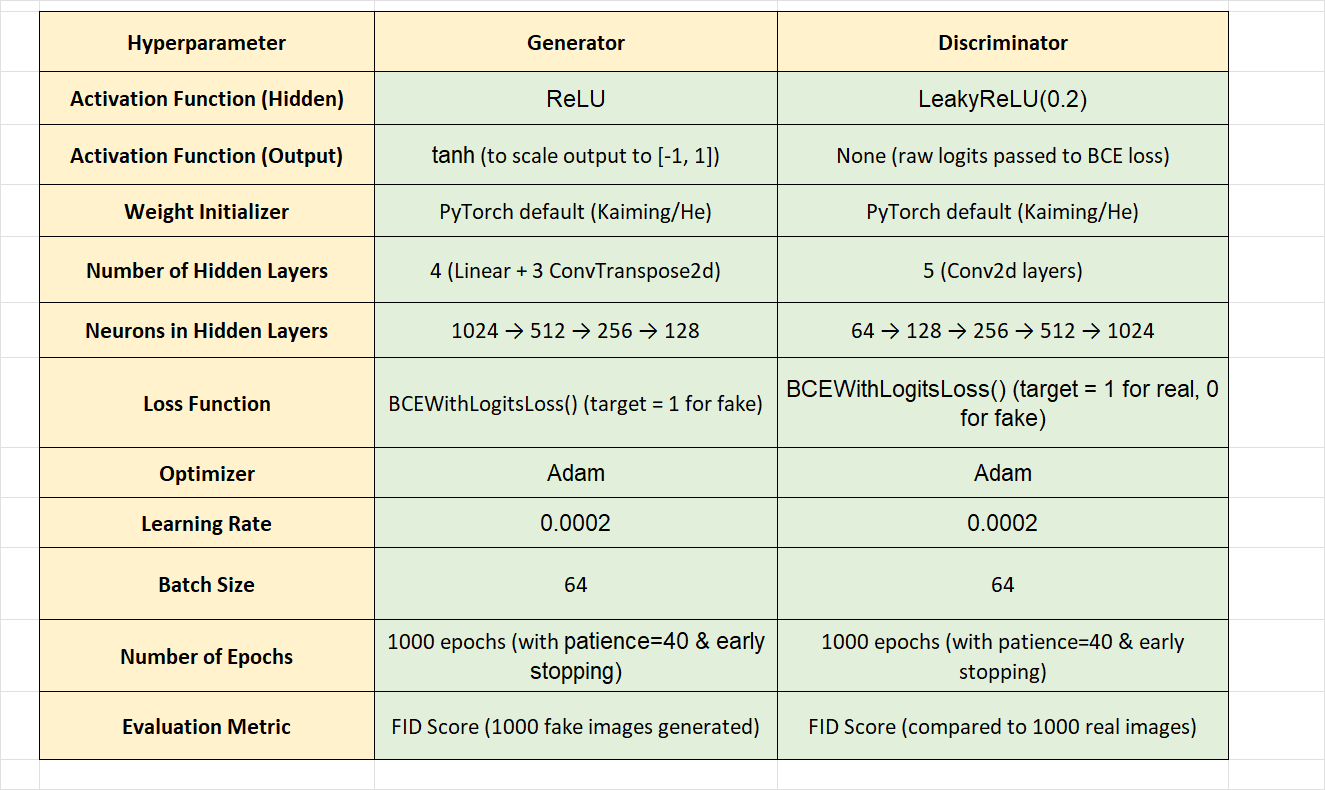
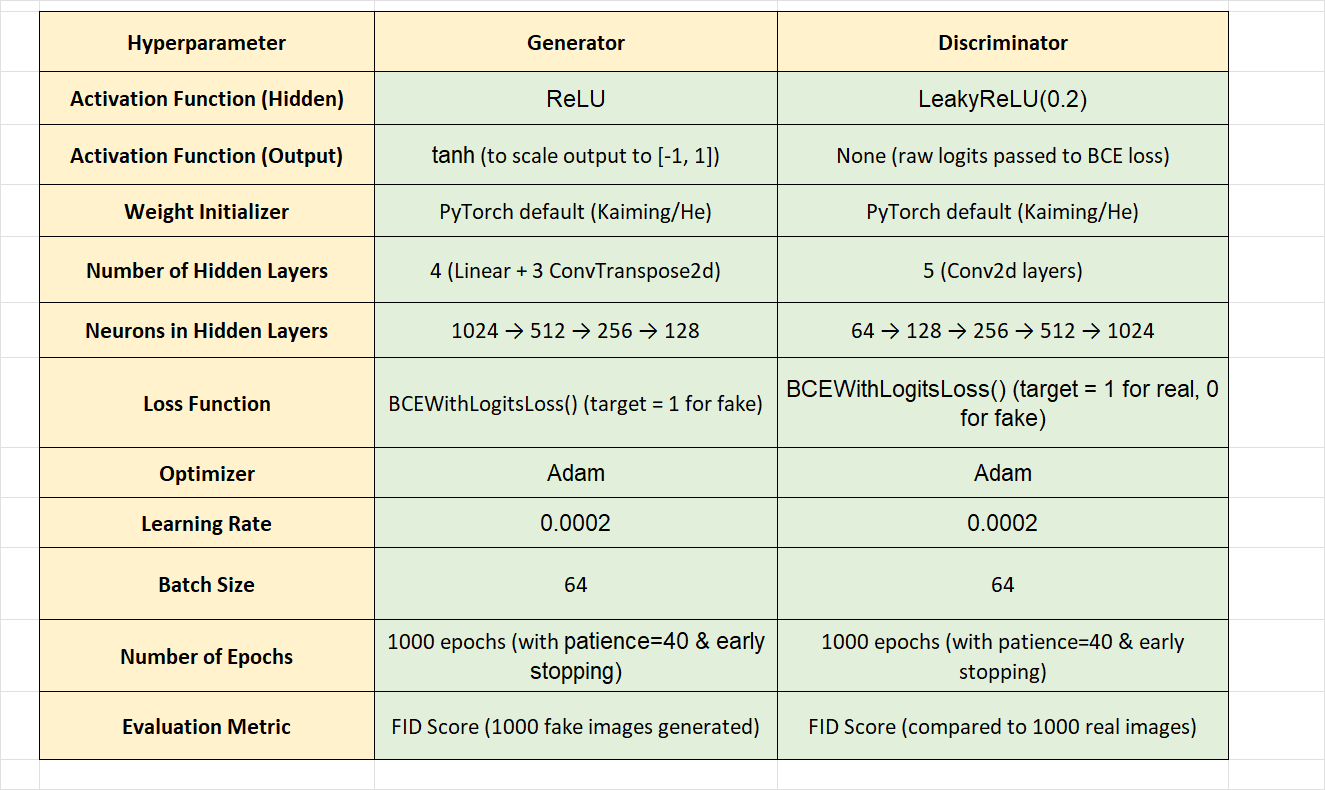
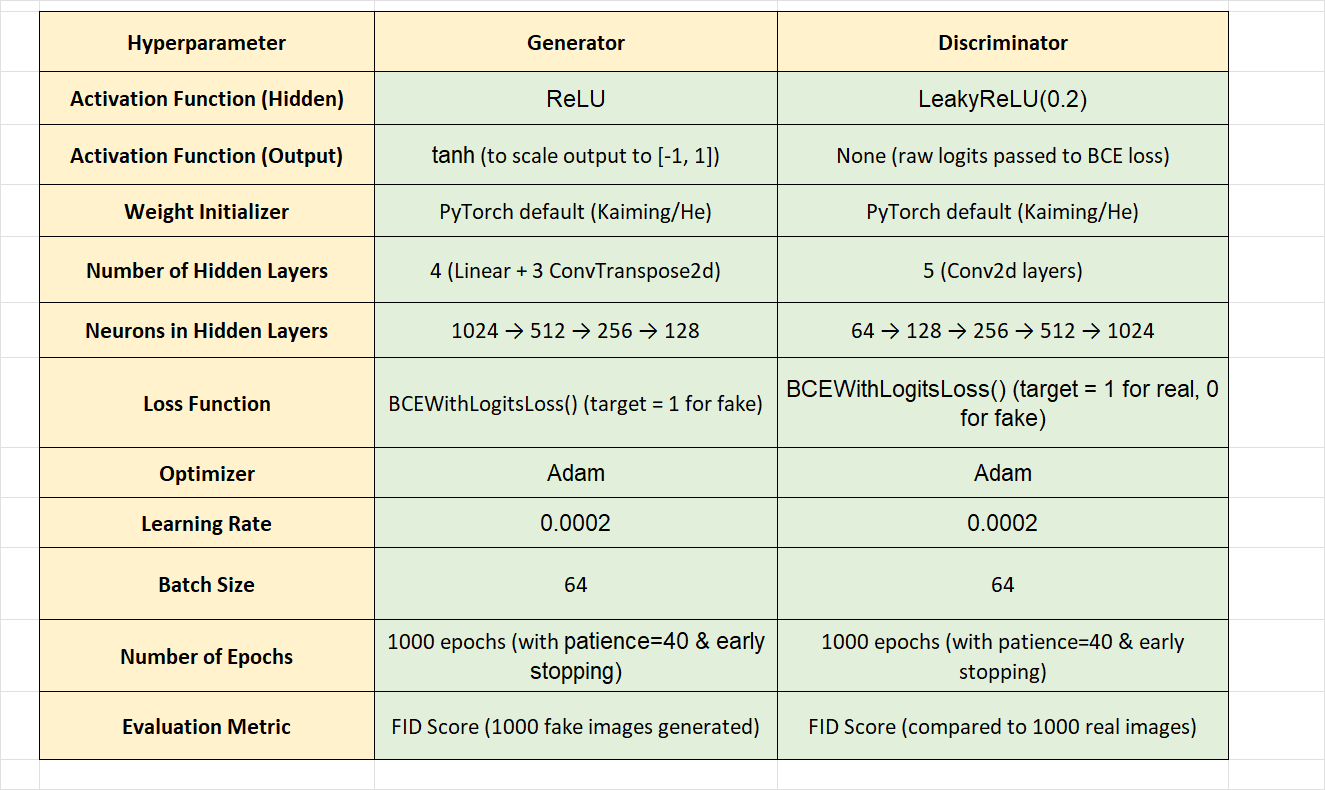